# COVID-19 Tanulmányok Elemzése

Ebben a kihívásban továbbra is a COVID-járvány témájával foglalkozunk, és a témával kapcsolatos tudományos tanulmányok feldolgozására koncentrálunk. Létezik a [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge), amely több mint 7000 (az írás pillanatában) COVID-ról szóló tanulmányt tartalmaz, metaadatokkal és absztraktokkal (és körülbelül felük esetében teljes szöveg is elérhető).

A [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) kognitív szolgáltatás használatával végzett elemzés teljes példája [ebben a blogbejegyzésben](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) található. Mi ennek az elemzésnek egy egyszerűsített változatát fogjuk megvitatni.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Az adatok beszerzése

Először meg kell szereznünk a CORD tanulmányok metaadatait, amelyekkel dolgozni fogunk.

**NOTE**: Nem biztosítunk másolatot az adatkészletről ebben a tárolóban. Először le kell töltened a [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) fájlt [erről a Kaggle adatkészletről](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Ehhez regisztrációra lehet szükség a Kaggle-n. Az adatkészlet regisztráció nélkül is letölthető [innen](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), de ez a metaadat fájlon kívül az összes teljes szöveget is tartalmazni fogja.

Megpróbáljuk közvetlenül online forrásból beszerezni az adatokat, azonban ha ez nem sikerül, akkor le kell töltened az adatokat a fent leírt módon. Emellett érdemes letölteni az adatokat, ha később kísérletezni szeretnél velük, hogy időt takaríts meg a várakozással.

> **NOTE** Az adatkészlet meglehetősen nagy, körülbelül 1 Gb méretű, és az alábbi kódsor futtatása hosszú időt vehet igénybe! (~5 perc)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Most a publikáció dátumát tartalmazó oszlopot `datetime` formátumra alakítjuk, és hisztogramot készítünk, hogy lássuk a publikációs dátumok tartományát.


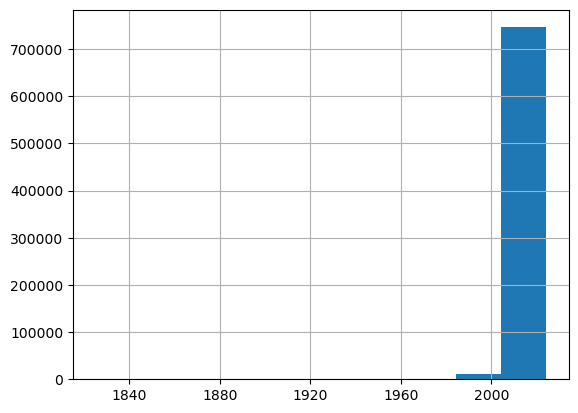

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Strukturált adatok kinyerése

Nézzük meg, milyen információkat tudunk könnyen kinyerni az absztraktokból. Az egyik dolog, ami érdekes lehet, az, hogy milyen kezelési stratégiák léteznek, és hogyan fejlődtek az idők során. Kezdetben manuálisan összeállíthatjuk a COVID kezelésére használt lehetséges gyógyszerek listáját, valamint a diagnózisok listáját. Ezután átnézzük ezeket, és megkeressük a megfelelő kifejezéseket a tanulmányok absztraktjaiban.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Hozzáadtunk egy sor oszlopot az adatkeretünkhöz, amelyek azt mutatják, hogy egy adott gyógyszer/diagnózis hányszor szerepel az absztraktban.

> **Megjegyzés**: Hozzáadunk egy szóközt a szó elejéhez, amikor egy részszöveget keresünk. Ha ezt nem tesszük meg, hibás eredményeket kaphatunk, mert például a *chloroquine* megtalálható lenne a *hydroxychloroquine* részszövegében is. Emellett az absztraktok oszlopát `str` típusra kényszerítjük, hogy elkerüljünk egy hibát – próbáld meg eltávolítani a `str`-t, és nézd meg, mi történik.

Az adatokkal való könnyebb munka érdekében kinyerhetjük az alkeretet, amely csak a gyógyszerszámokat tartalmazza, és kiszámíthatjuk az előfordulások összesített számát. Ez megmutatja a legnépszerűbb gyógyszert:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

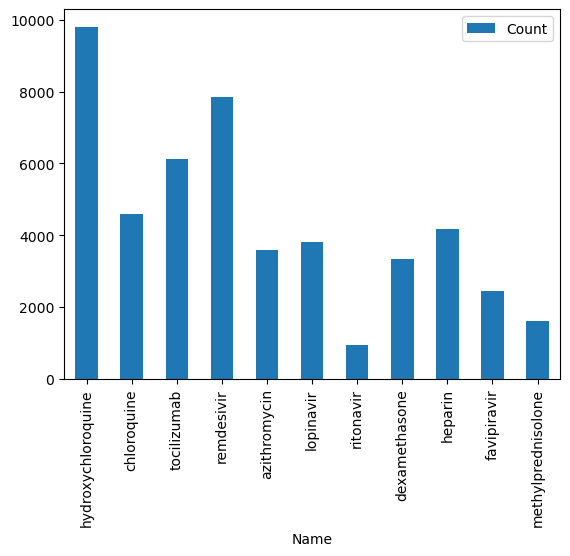

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Kezelési stratégiák trendjeinek keresése

A fenti példában összeadtuk az összes értéket, de ugyanezt megtehetjük havi bontásban is:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

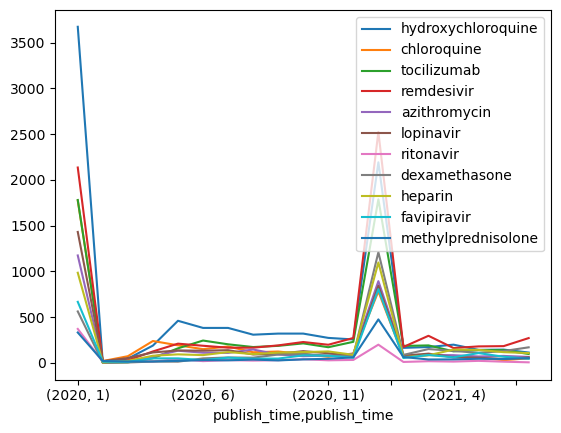

In [152]:
dfmt.plot()
plt.show()

Egy érdekes megfigyelés, hogy két helyen hatalmas kiugrásokat látunk: 2020. januárjában és 2021. januárjában. Ennek oka, hogy néhány cikk esetében nincs pontosan megadva a publikáció dátuma, és ezek az adott év januárjára vannak beállítva.

Hogy jobban érthetővé tegyük az adatokat, nézzünk meg csak néhány gyógyszert. Emellett "kitöröljük" a januári adatokat, és helyettesítjük őket valamilyen közepes értékkel, hogy szebb grafikont kapjunk:


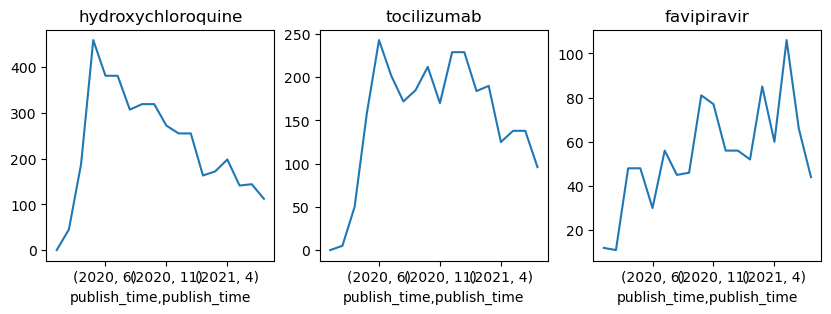

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

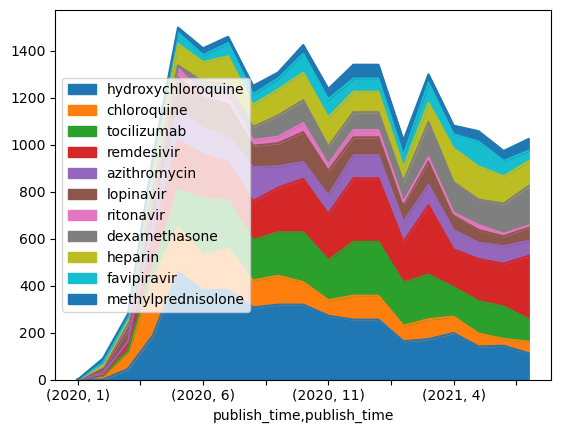

In [154]:
dfmt.plot.area()
plt.show()

Még továbbmenve, kiszámíthatjuk a relatív népszerűséget százalékban:


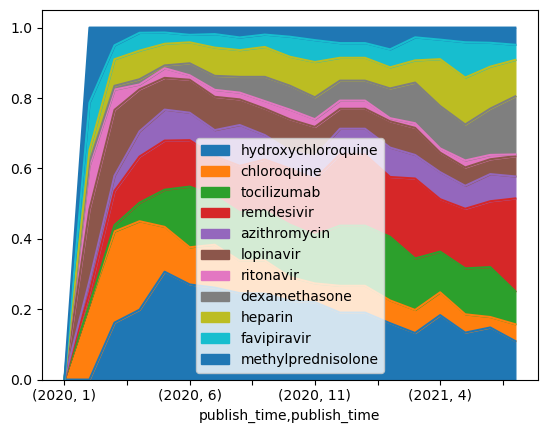

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Gyógyszer-diagnózis megfeleltetés

Az egyik legérdekesebb kapcsolat, amit vizsgálhatunk, az, hogy különböző diagnózisokat hogyan kezelnek különböző gyógyszerekkel. Ennek szemléltetéséhez egy **együtt-előfordulási gyakorisági térképet** kell létrehoznunk, amely megmutatja, hogy két kifejezés hányszor szerepel ugyanabban a tanulmányban.

Ez a térkép lényegében egy 2D mátrix, amelyet legjobban egy **numpy array** formájában lehet ábrázolni. A térképet úgy számítjuk ki, hogy végigmegyünk az összes absztrakton, és megjelöljük az ott előforduló entitásokat:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Az egyik módja ennek a mátrixnak a megjelenítésére egy **hőtérkép** rajzolása:


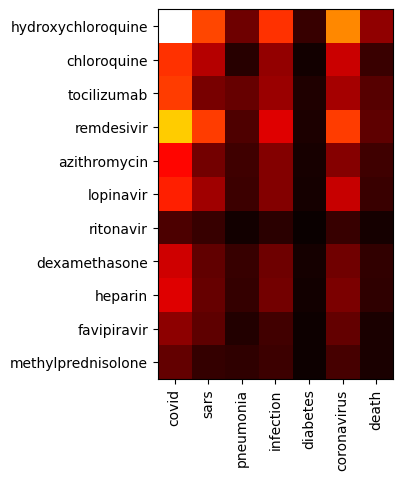

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Az úgynevezett **Sankey** diagram segítségével még jobb vizualizáció érhető el! A `matplotlib` nem rendelkezik beépített támogatással ehhez a diagramtípushoz, ezért a [Plotly](https://plotly.com/python/) könyvtárat kell használnunk, ahogy azt [ebben a bemutatóban](https://plotly.com/python/sankey-diagram/) leírják.

A Plotly Sankey diagram elkészítéséhez a következő listákat kell összeállítanunk:
* Az `all_nodes` lista, amely tartalmazza a gráf összes csomópontját, beleértve a gyógyszereket és a diagnózisokat is
* Forrás- és célindexek listája - ezek a listák mutatják meg, hogy mely csomópontok kerülnek a diagram bal, illetve jobb oldalára
* Az összes kapcsolat listája, ahol minden kapcsolat tartalmazza:
   - A forrás indexét az `all_nodes` tömbben
   - A cél indexét
   - Egy értéket, amely a kapcsolat erősségét jelzi. Ez pontosan az érték a társ-előfordulási mátrixunkból.
   - Opcionálisan a kapcsolat színét. Lehetőségünk lesz kiemelni néhány kifejezést az érthetőség kedvéért.

A Sankey diagram megrajzolására szolgáló általános kód egy külön `sankey` függvényben van felépítve, amely két listát (forrás- és célkategóriák) és egy társ-előfordulási mátrixot vesz át. Emellett lehetőséget biztosít küszöbérték megadására, amely alapján kihagyhatjuk azokat a kapcsolatokat, amelyek gyengébbek a megadott küszöbnél - ezáltal a diagram kevésbé lesz zsúfolt.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Következtetés

Láthattuk, hogy viszonylag egyszerű módszerekkel is kinyerhetünk információkat nem strukturált adatforrásokból, például szövegből. Ebben a példában meglévő gyógyszerlistát használtunk, de sokkal hatékonyabb lenne természetes nyelvfeldolgozási (NLP) technikákat alkalmazni az entitások kinyerésére szövegből. [Ebben a blogbejegyzésben](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) bemutatjuk, hogyan használhatók felhőszolgáltatások az entitások kinyerésére. Egy másik lehetőség a Python NLP könyvtárak, például az [NLTK](https://www.nltk.org/) használata - az NLTK-val történő információkinyerés megközelítését [itt](https://www.nltk.org/book/ch07.html) ismertetjük.


## Kihívás

Folytassa a COVID tanulmány adatainak kutatását az alábbi irányvonalak mentén:

1. Készítsen együtt-előfordulási mátrixot különböző gyógyszerekről, és vizsgálja meg, mely gyógyszerek fordulnak elő gyakran együtt (azaz egy absztraktban említve). Módosíthatja a kódot a gyógyszerek és diagnózisok együtt-előfordulási mátrixának létrehozásához.
1. Vizualizálja ezt a mátrixot hőtérképen.
1. Kihívásként megpróbálhatja vizualizálni a gyógyszerek együtt-előfordulását [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) segítségével. [Ez a könyvtár](https://pypi.org/project/chord/) segíthet chord diagram rajzolásában.
1. Egy másik kihívásként próbálja meg kinyerni a különböző gyógyszerek adagolását (például **400mg** az *napi 400mg chloroquine szedése* esetében) reguláris kifejezések használatával, és készítsen egy adatkeretet, amely bemutatja a különböző gyógyszerek különböző adagolásait. **Megjegyzés**: vegye figyelembe a gyógyszer neve közelében található numerikus értékeket.



---

**Felelősség kizárása**:  
Ez a dokumentum az AI fordítási szolgáltatás, a [Co-op Translator](https://github.com/Azure/co-op-translator) segítségével lett lefordítva. Bár törekszünk a pontosságra, kérjük, vegye figyelembe, hogy az automatikus fordítások hibákat vagy pontatlanságokat tartalmazhatnak. Az eredeti dokumentum az eredeti nyelvén tekintendő hiteles forrásnak. Kritikus információk esetén javasolt professzionális emberi fordítást igénybe venni. Nem vállalunk felelősséget semmilyen félreértésért vagy téves értelmezésért, amely a fordítás használatából eredhet.
